Final Project - Machine Learning
- Daniel Jönsson & Mustafa Al-Bayati
- Group 10

## Dependencies

In [97]:
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1. Data Loading

In [99]:
# load the dataset using latin-1 encoding to avoid encoding issues
df = pd.read_csv('spam.csv', encoding='latin-1')

# display the shape and info of the dataset, also the first 5 rows
print(f'Dataset shape: {df.shape}')
print(df.info())
df.head()


Dataset shape: (5572, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# 2. Preprocessing & Cleaning

## 2.1 Remove unneccessary columns

In [100]:
# drop unnamed columns  
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

## 2.2 Rename columns

In [101]:
df = df.rename(columns={'v1': 'category', 'v2': 'message'})

df.head()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2.3 Check for null values

In [102]:
# check for missing values in each column
df.isnull().sum()

category    0
message     0
dtype: int64

## 2.4 Check for duplicates & drop

In [103]:
# check for duplicate rows
print(df.duplicated().sum())

# remove duplicate rows
df = df.drop_duplicates()

# print duplicates after removal
print(df.duplicated().sum())

403
0


## 2.5 Change target ham/spam to 0 and 1

In [104]:
# use encoding to convert 'ham' to 0 and 'spam' to 1
def encode_category(category):
    if category == 'ham':
        return 0
    else:
        return 1
    
df['category'] = df['category'].apply(encode_category)

## 2.6 New column messages to lowercase

In [105]:
# change all messages to lowercase
df['message_lower'] = df['message'].str.lower()

## 2.7 Display data after cleaning

In [106]:
df

,category,message,message_lower
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,will ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s..."
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


In [107]:
# use value_counts to see the distribution of categories
print(df['category'].value_counts())

category
0    4516
1     653
Name: count, dtype: int64


# 3. Feature Engineering

## 3.1 Message Length

In [108]:
# message length
df['message_length'] = df['message'].str.len()

## 3.2 Word Count

In [109]:
# word count
def word_counter(message):
    count = 0
    for word in message.split():
        count += 1
    return count

df['word_count'] = df['message'].apply(word_counter)

## 3.3 Has Numbers

In [110]:
# checks for numbers in the message
def has_numbers(message):
    for char in message:
        if char.isdigit():
            return 1
    return 0

df['has_numbers'] = df['message'].apply(has_numbers)

## 3.4 Has Link

In [111]:
# checks if message has links
links = ['http', 'www.', '.com', '.net', '.org', '.se']

def has_link(message):
    for link in links:
        if link in message.lower():
            return 1
    return 0
df['has_link'] = df['message_lower'].apply(has_link)

## 3.5 Count of suspicious words

In [112]:
# checks if message has suspicious words
# make a list of some suspicious words that we assume are more likely to be in spam messages
suspicious_words = ['free',
                     'win',
                    'winner', 
                    'cash', 
                    'prize', 
                    'urgent', 
                    'claim', 
                    'offer', 
                    'buy', 
                    'credit', 
                    'loan', 
                    'click', 
                    'subscribe', 
                    'limited', 
                    'guarantee',
                    'risk-free',
                    'act now',
                    'exclusive',
                    'instant',
                    'gift',
                    'bonus',
                    'trial',
                    'cheap'
                    ]

def count_suspicious_words(message):
    count = 0
    for word in suspicious_words:
        if word in message:
            count += 1
    return count

# use message lower to count suspicious words
df['suspicious_word_count'] = df['message_lower'].apply(count_suspicious_words)

## 3.6 Count of uppercase letters

In [113]:
# check how many uppercase letters are in the message
def count_uppercase_letters(message):
    count = 0
    for char in message:
        if char.isupper():
            count += 1
    return count

df['uppercase_letter_count'] = df['message'].apply(count_uppercase_letters)

## 3.7 Handle Outliers

In [114]:
# remove outliers on numerical columns with zscore
def remove_outliers(df, col):
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    return df[z_scores.abs() <= 3]

print(f'before removing outliers: {df.shape}')
df = remove_outliers(df, 'message_length')
df = remove_outliers(df, 'word_count')
df = remove_outliers(df, 'suspicious_word_count')
df = remove_outliers(df, 'uppercase_letter_count')
print(f'after removing outliers: {df.shape}')

before removing outliers: (5169, 9)
after removing outliers: (4796, 9)


In [115]:
df.head()

,category,message,message_lower,message_length,word_count,has_numbers,has_link,suspicious_word_count,uppercase_letter_count
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",111,20,0,0,0,3
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,29,6,0,0,0,2
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,49,11,0,0,0,2
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",61,13,0,0,0,2
5,1,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it's been 3 week's n...,148,32,1,0,1,7


# 4. Visualizations

## 4.1 Values by Category

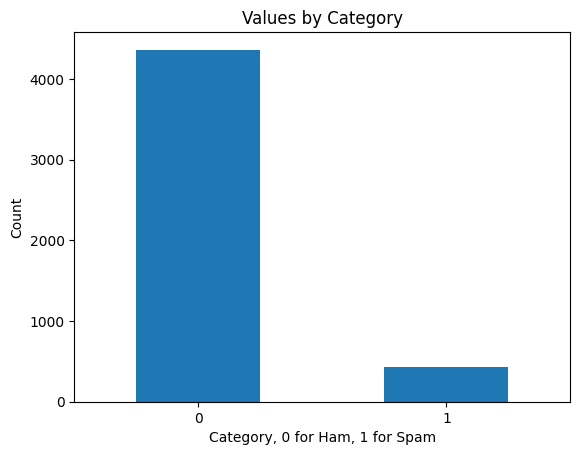

In [116]:
# plot how many messages are ham and how many are spam
df['category'].value_counts().plot(kind='bar')
plt.title('Values by Category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 4.2 Average Message Length by Category

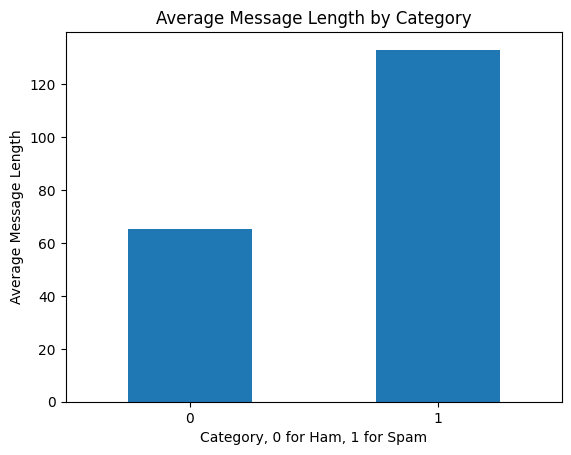

In [117]:
# make a bar plot for average message length by category
df.groupby('category')['message_length'].mean().plot(kind='bar')
plt.title('Average Message Length by Category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Average Message Length')
plt.xticks(rotation=0)
plt.show()

## 4.3 Average Word Count by Category

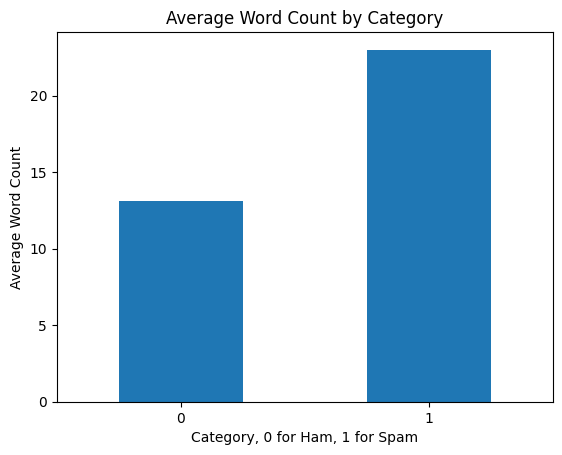

In [118]:
# word Count by Category
df.groupby('category')['word_count'].mean().plot(kind='bar')
plt.title('Average Word Count by Category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.show()

## 4.4 Has numbers by category

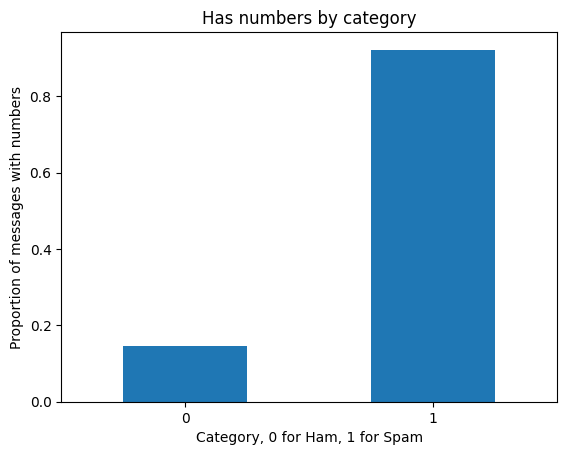

In [119]:
# compare how many messages have numbers by category
df.groupby('category')['has_numbers'].mean().plot(kind='bar')
plt.title('Has numbers by category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Proportion of messages with numbers')
plt.xticks(rotation=0)
plt.show()

## 4.5 Has link

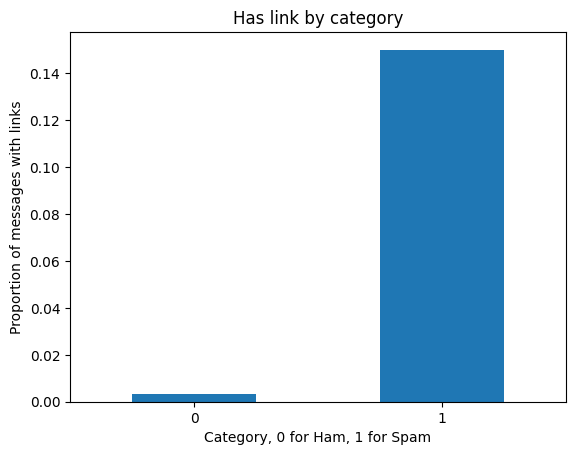

In [120]:
# compare how many message have links by category
df.groupby('category')['has_link'].mean().plot(kind='bar')
plt.title('Has link by category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Proportion of messages with links')
plt.xticks(rotation=0)
plt.show()

## 4.6 Average count of suspicious words by category

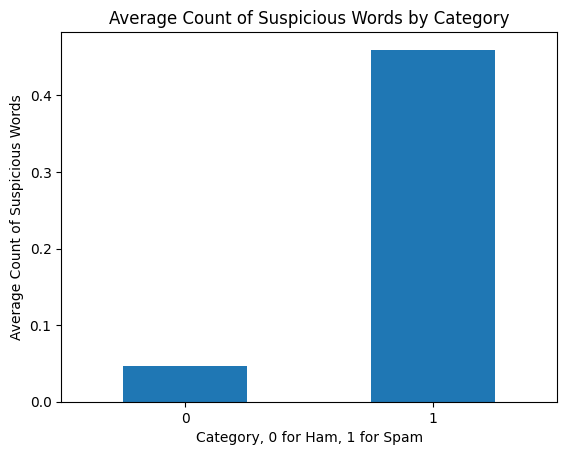

In [121]:
# show on average how many suspicious words are in messages by category
df.groupby('category')['suspicious_word_count'].mean().plot(kind='bar')
plt.title('Average Count of Suspicious Words by Category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Average Count of Suspicious Words')
plt.xticks(rotation=0)
plt.show()

## 4.7 Average count of uppercase letters by category

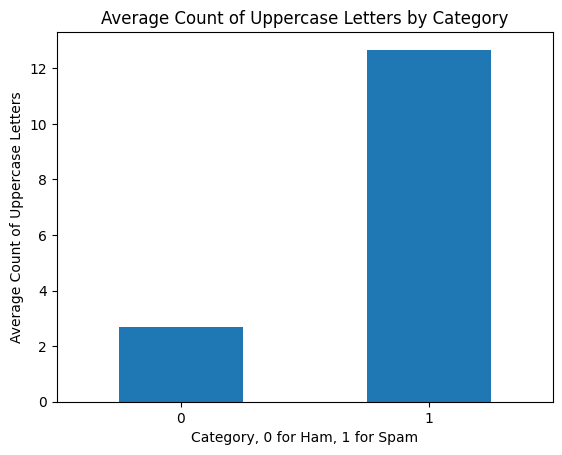

In [122]:
# average count of uppercase letters by category
df.groupby('category')['uppercase_letter_count'].mean().plot(kind='bar')
plt.title('Average Count of Uppercase Letters by Category')
plt.xlabel('Category, 0 for Ham, 1 for Spam')
plt.ylabel('Average Count of Uppercase Letters')
plt.xticks(rotation=0)
plt.show()

## 4.8 Distribution of Message Length for Ham

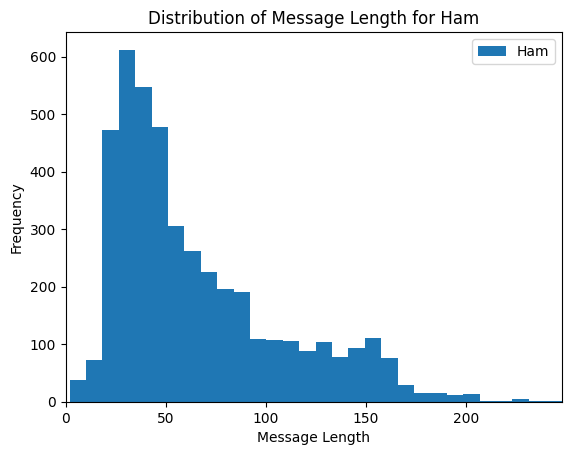

In [123]:
# Distribution of category = 0 (ham)
plt.hist(df[df['category'] == 0]['message_length'], bins=30, label='Ham')
plt.title('Distribution of Message Length for Ham')
# add max message length to x axis using xlim that sets x axis from 0 to max message length
plt.xlim(0, df['message_length'].max())
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 4.9 Distribution of Message Length for Spam

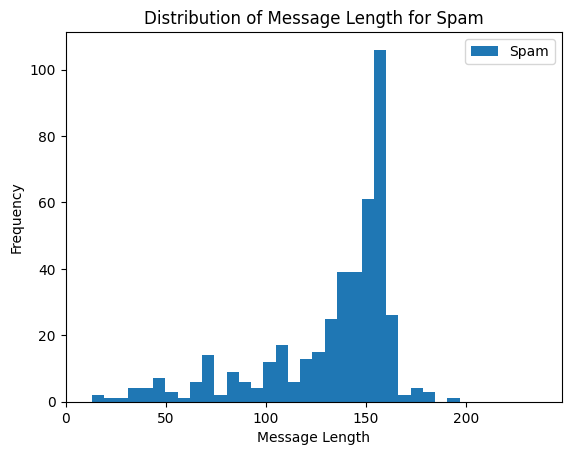

In [124]:
## Distribution of category = 1 (spam)
plt.hist(df[df['category'] == 1]['message_length'], bins=30, label='Spam')
plt.title('Distribution of Message Length for Spam')
# add max message length to x axis using xlim that sets x axis from 0 to max message length
plt.xlim(0, df['message_length'].max())
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 5. Preparing data for model

## 5.1 Select columns for features x and target y

In [125]:
X = df[['message_length', 'word_count', 'has_numbers', 'has_link', 'suspicious_word_count', 'uppercase_letter_count']]
y = df['category']

## 5.2 Split data for training and test

In [126]:
# split data for training and testing
# stratify to maintain the proportion of classes in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 5.3 Scale features to be fair

In [127]:
# scale features with standard scaler so one unit in feature is one standard deviation
# especially important for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Training Models

## 6.1 Logistic Regression from Scratch

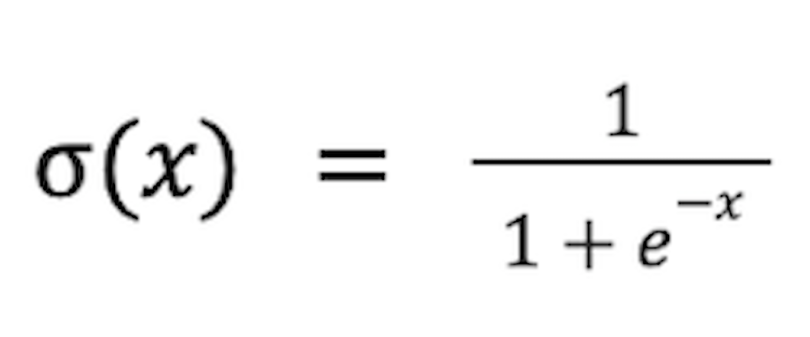

In [ ]:
# define the sigmoid function 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# w is weights, b is bias
# initialize weights to zeros using numpy
# and bias to 0
# using 6 features for weights (our 6 columns we feature engineered) to train the model
w = np.zeros(6)
b = 0

# 1000 iterations of gradient descent to optimize weights and bias
for _ in range(1000):
    # this p is the predicted probability, changing depending on current weights and bias
    p = sigmoid(X_train_scaled @ w + b)
    # update weights and bias
    w -= 0.01 * (X_train_scaled.T @ (p - y_train)) / len(y_train)
    b -= 0.01 * np.sum(p - y_train) / len(y_train)

# make predictions using the learned weights and bias
# apply sigmoid and threshold at 0.5
y_pred = (sigmoid(X_test_scaled @ w + b) >= 0.5).astype(int)

print("Metrics for Logistic Regression from Scratch model:")

# check accuracy
lrs_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {lrs_accuracy:10.2f}")

# check recall
lrs_recall = recall_score(y_test, y_pred)
print(f"Recall: {lrs_recall:12.2f}")

# check precision
lrs_precision = precision_score(y_test, y_pred)
print(f"Precision: {lrs_precision:9.2f}")

# check f1 score
lrs_f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {lrs_f1:10.2f}")

# check confusion matrix
lrs_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
lrs_cm = confusion_matrix(y_test, y_pred)
print(lrs_cm)

# check classification report
lrs_cr = classification_report(y_test, y_pred)
print(lrs_cr)

ValueError: operands could not be broadcast together with shapes (6,) (3836,) (6,) 

## 6.2 Logistic Regression

In [ ]:
# create the model for logistic regression
lr_model = LogisticRegression(random_state=42)

# train model
lr_model.fit(X_train_scaled, y_train)

# make predictions
y_pred = lr_model.predict(X_test_scaled)

print("Metrics for Logistic Regression Model:")

# check accuracy
lr_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {lr_accuracy:10.2f}")

# check recall
lr_recall = recall_score(y_test, y_pred)
print(f"Recall: {lr_recall:12.2f}")

# check precision
lr_precision = precision_score(y_test, y_pred)
print(f"Precision: {lr_precision:9.2f}")

# check f1 score
lr_f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {lr_f1:10.2f}")


# check confusion matrix
lr_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(lr_cm)

# check classification report
lr_cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(lr_cr)
